In [0]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score


# In[5]:


import keras


# In[61]:


# Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(1)     

import matplotlib.pyplot as plt

In [0]:
#TEST_NAME = "KMeans"
TEST_NAME = "PageRank"
#TEST_NAME = "SGD"

#plt.style.use('ggplot')

def plot_history(history):
    #acc = history.history['r2_score_other']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    #plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    #plt.plot(x, acc, 'b', label='Training r2_score')
    #plt.plot(x, val_acc, 'r', label='Validation acc')
    #plt.title('Training and validation accuracy')
    #plt.legend()
    #plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


# In[42]:

def add_context(data_df, context = 0):

    L = len(data_df)
    cols = list(data_df.columns)

    context_data = []
    
    row_1 = np.asarray(data_df.iloc[0,:])
    row_1 = np.reshape(row_1,(1,-1))
    row_1 = pd.DataFrame(row_1, columns=cols)
    #pad data with data[0] context times
    data = pd.concat([row_1]*context + [data_df])
    
    try:
        del data[0]
    except:
        pass
    
    data = data.to_numpy()
    
    
    for fi in range(context, len(data)):
        frame = data[fi-context:fi+1].flatten()
        context_data.append(frame)
    
    return pd.DataFrame(context_data, columns = cols*(context+1))

def read_dataset(filename):
    dataset = pd.read_csv(filename)
    return dataset

def get_data_labels(df, context = 0):
    label = df['flow_size']
    try:
      del df['job']
    except:
      pass
    df = add_context(df, context)
    df.iloc[:, -1] = 0
    #add context to labels
    return df, label



# # Neural Network


#from keras import optimizers
#adam = optimizers.Adam(lr=0.9)


# In[90]:


#r2 score used in paper. 1 is best. -1 is bad.

def r2_score_other(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


#from https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))

train_df = read_dataset(TEST_NAME+'_training.csv')
test_df = read_dataset(TEST_NAME+'_test.csv')
validation_df = read_dataset(TEST_NAME+'_validation.csv')

#all will have same columns
cols = train_df.columns

#scale and convert to df
train_df = scaler.fit_transform(train_df)
train_df = pd.DataFrame(train_df, columns = cols)

test_df = scaler.transform(test_df)
test_df = pd.DataFrame(test_df, columns = cols)

validation_df = scaler.transform(validation_df)
validation_df = pd.DataFrame(validation_df, columns = cols)

context = 1

train_x, train_y = get_data_labels(train_df, context)
test_x, test_y = get_data_labels(test_df, context)
validation_x, validation_y = get_data_labels(validation_df, context)

In [0]:
train_x.shape, train_y.shape

((54646, 16), (54646,))

In [0]:
#define callback for early stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=50)

#define callback for saving best model
model_name = 'nn_model_' + TEST_NAME + str(context) + 'context' + '.h5'
best_model = ModelCheckpoint(model_name, monitor='val_loss',mode='min')

In [0]:
# In[102]:

'''
model = Sequential()
model.add(Dense(5, input_dim=train_x.shape[1],activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='relu'))
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = [r2_score_other])
model.fit(train_x, train_y, epochs=250, batch_size=10)
'''

model = Sequential()
model.add(Dense(5, input_dim=train_x.shape[1], activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_absolute_error', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, \
                      validation_data = (validation_x, validation_y), \
                      batch_size=10, verbose=2, callbacks = [early_stop, best_model])

#plot_history(history)

#error metric
model.evaluate(test_x, test_y)

Train on 54646 samples, validate on 15695 samples
Epoch 1/100
 - 6s - loss: 0.0066 - val_loss: 0.0021
Epoch 2/100
 - 6s - loss: 0.0020 - val_loss: 0.0021
Epoch 3/100
 - 6s - loss: 0.0019 - val_loss: 0.0019
Epoch 4/100
 - 6s - loss: 0.0018 - val_loss: 0.0018
Epoch 5/100
 - 6s - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
 - 6s - loss: 0.0013 - val_loss: 0.0015
Epoch 7/100
 - 6s - loss: 0.0013 - val_loss: 0.0013
Epoch 8/100
 - 6s - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
 - 6s - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
 - 6s - loss: 0.0011 - val_loss: 0.0012
Epoch 11/100
 - 6s - loss: 0.0011 - val_loss: 0.0011
Epoch 12/100
 - 6s - loss: 0.0011 - val_loss: 0.0010
Epoch 13/100
 - 6s - loss: 0.0010 - val_loss: 0.0010
Epoch 14/100
 - 6s - loss: 0.0010 - val_loss: 9.5256e-04
Epoch 15/100
 - 6s - loss: 9.9182e-04 - val_loss: 9.4809e-04
Epoch 16/100
 - 6s - loss: 9.8574e-04 - val_loss: 9.4579e-04
Epoch 17/100
 - 6s - loss: 0.0010 - val_loss: 9.2373e-04
Epoch 18/100
 - 6s - loss: 9.6696e

0.0008432364022130476

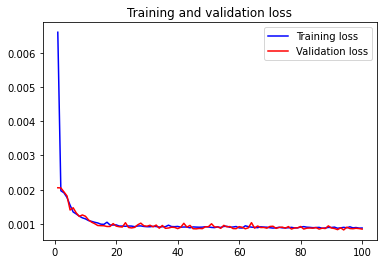

In [0]:
plot_history(history)

In [0]:
#save final model also
model.save('final'+model_name)

pred_y = model.predict(test_x)
score = r2_score(test_y, pred_y)
print(f'Test r2 score: {score}')


Test r2 score: 0.9230956554054428


In [0]:
from keras.models import load_model

saved_model = load_model('finalnn_model_PageRank1context.h5')
pred_y = saved_model.predict(test_x)
score = r2_score(test_y, pred_y)
print(f'Test r2 score: {score}')

Test r2 score: 0.9230956554054428


In [253]:
history = model.fit(train_x, train_y, epochs=100, \
                      validation_data = (validation_x, validation_y), \
                      batch_size=10, verbose=2, callbacks = [early_stop, best_model])

pred_y = model.predict(test_x)
score = r2_score(test_y, pred_y)
print(f'Test r2 score: {score}')

Train on 54646 samples, validate on 15695 samples
Epoch 1/100
 - 6s - loss: 8.8314e-04 - val_loss: 8.4001e-04
Epoch 2/100
 - 6s - loss: 8.8094e-04 - val_loss: 8.5468e-04
Epoch 3/100
 - 6s - loss: 8.7457e-04 - val_loss: 8.8203e-04
Epoch 4/100
 - 6s - loss: 8.9701e-04 - val_loss: 8.7858e-04
Epoch 5/100
 - 6s - loss: 9.0467e-04 - val_loss: 9.0176e-04
Epoch 6/100
 - 6s - loss: 8.8233e-04 - val_loss: 8.4948e-04
Epoch 7/100
 - 6s - loss: 8.8587e-04 - val_loss: 8.6156e-04
Epoch 8/100
 - 6s - loss: 8.7894e-04 - val_loss: 9.1089e-04
Epoch 9/100
 - 6s - loss: 8.9530e-04 - val_loss: 9.3459e-04
Epoch 10/100
 - 6s - loss: 8.7954e-04 - val_loss: 8.5337e-04
Epoch 11/100
 - 6s - loss: 8.9358e-04 - val_loss: 8.7116e-04
Epoch 12/100
 - 6s - loss: 8.6110e-04 - val_loss: 8.5881e-04
Epoch 13/100
 - 6s - loss: 8.7985e-04 - val_loss: 9.7765e-04
Epoch 14/100
 - 6s - loss: 8.8875e-04 - val_loss: 8.6442e-04
Epoch 15/100
 - 6s - loss: 8.7354e-04 - val_loss: 8.6909e-04
Epoch 16/100
 - 6s - loss: 9.0084e-04 - val_

In [257]:
pred_y = model.predict(test_x)
score = r2_score(test_y, pred_y)
print(f'Test r2 score: {score}')

#model.save('final'+model_name)


Test r2 score: 0.9418584675426599


In [268]:
test_mini_df = read_dataset('PageRank_test_jb_mini_test_1.csv')
#jobs = test_mini_df['job']
#del test_mini_df['job']

#get original test_df
test_df['flow_size'] = pred_y
#print(test_df.tail())
unscaled_test_df = scaler.inverse_transform(test_df)
unscaled_test_df = pd.DataFrame(unscaled_test_df, columns = cols)
#change_cols = {"agg_net_out":'int32', "agg_net_in":'int32', "agg_net_out_per_machine":'int32','agg_net_in_per_machine':'int32','machine':'int32','flow_size':'int32'}
#unscaled_test_df = unscaled_test_df.astype(change_cols)
unscaled_test_df.tail(20)


,time,flow_frequency,agg_net_out,agg_net_in,agg_net_out_per_machine,agg_net_in_per_machine,machine,flow_size
14794,102.15,7.65,190811027.0,767966981.0,1811577.0,1687049.0,4.0,1002.0
14795,102.25,0.10,191735863.0,767980802.0,7895583.0,178595.0,5.0,1002.0
14796,102.45,0.15,193350507.0,768003686.0,8375499.0,179687.0,5.0,1002.0
14797,102.55,0.10,194156699.0,768016991.0,8532039.0,179739.0,5.0,1002.0
14798,102.65,0.10,194912748.0,768027205.0,8794443.0,180467.0,5.0,1002.0
14799,102.85,0.20,196427263.0,768052271.0,9056847.0,181351.0,5.0,1002.0
14800,103.00,0.10,198154419.0,768072334.0,9844059.0,183587.0,5.0,1002.0
14801,103.20,1.05,200738883.0,768103241.0,1813039.0,1687273.0,4.0,1002.0
14802,103.40,0.10,202968838.0,768130312.0,12349199.0,192427.0,5.0,1002.0
14803,107.20,4.00,239656636.0,768647476.0,1814501.0,1687497.0,4.0,1002.0


In [267]:
unscaled_test_df.loc[unscaled_test_df['flow_size'].idxmax()]

time                       1.385500e+02
flow_frequency             1.320000e+01
agg_net_out                1.027385e+08
agg_net_in                 1.369980e+09
agg_net_out_per_machine    3.154502e+06
agg_net_in_per_machine     3.080607e+06
machine                    4.000000e+00
flow_size                  4.114875e+08
Name: 1942, dtype: float64

In [270]:
unscaled_test_df.loc[1942]['flow_size']

411487522.8759811

In [0]:
new_df = pd.DataFrame([])
new_df['flow_size'] = test_mini_df['flow_size']
new_df['job'] = test_mini_df['job']
new_df['predicted_flow_size'] = test_mini_df['flow_size']

#now copy predicted
for index, row in test_mini_df.iterrows():
  i = int(row['pseudo_index'])
  new_df.iloc[index,2] = unscaled_test_df.iloc[i]['flow_size']

In [249]:
new_df.head(10)

,flow_size,job,predicted_flow_size
0,1576.0,1,1002.000001
1,2777.0,1,1002.000002
2,4763.0,1,1002.000215
3,1494.0,1,1002.001862
4,30717.0,1,1002.001983
5,3560.0,1,1002.002916
6,15372.0,1,1002.001450
7,22817.0,1,1002.000000
8,2061.0,1,1002.000000
9,1576.0,1,1002.000000


In [209]:
test_mini_df.head()

,pseudo_index,time,flow_frequency,agg_net_out,agg_net_in,agg_net_out_per_machine,agg_net_in_per_machine,machine,flow_size,job
0,0,14.50,4.80,1576.0,52.0,1576.0,52.0,4,1576.0,1
1,1,16.25,1.75,4353.0,3078.0,4353.0,3078.0,4,2777.0,1
2,2,16.55,0.15,9116.0,5207.0,9116.0,5207.0,4,4763.0,1
3,3,16.80,0.25,10610.0,5431.0,10610.0,5431.0,4,1494.0,1
4,4,17.10,0.10,41327.0,72699.0,41327.0,72699.0,4,30717.0,1


In [0]:
unscaled_test_df.head()

,time,flow_frequency,agg_net_out,agg_net_in,agg_net_out_per_machine,agg_net_in_per_machine,machine,flow_size
0,14.50,4.80,1576,52,1576,52,4,1576
1,16.25,1.75,4353,3078,4353,3078,4,2777
2,16.55,0.15,9116,5207,9116,5207,4,4762
3,16.80,0.25,10610,5431,10610,5431,4,1494
4,17.10,0.10,41327,72699,41327,72699,4,30717


In [0]:
new_df.to_csv('PageRank_test_jb_mini_predicted_no_outliers.csv')